# Description
Makes an image of a 2D slice of the density field around the most massive halo for each density bin separately and for all combined. This shows that low density tracers (typically a bias close to zero) are much more abundant and form a more random appearing field, while structure becomes increasingly visible with increasing density. A slice in $x-y$ coordinates will be plotted, considering all galaxies which are positioned within a specified $xy$ window and within a set line of sight depth along the $z$ axis. The coordinates of this region are stored to disk.

Afterwards, one can also produce an image of the whole density field of a single percentile with a manually set line of sight depth.

Using the nbodykit FITSCatalog is significantly slower (factor 7) compared to using the fitsio library directly and reduce the catalog to the columns of interest.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import fitsio

In [3]:
# load catalog and seletion array for every density percentile 
filepath = '/disk11/salam/FirstGenMocks/AbacusSummit/CubicBox/BGS_v2/z0.200/AbacusSummit_base_c000_ph006/BGS_box_ph006.fits'
cat = fitsio.read(filepath, columns=['x','y','z','HALO_MASS'])
BoxSize = 2000 # Gpc/h

In [4]:
def coord_bounds(lower, upper, BoxSize, WindowSize):
    '''Update coordinate limits to assure that figure only contains positive x and y values
    but is of size window_size'''
    if lower < 0:
        lower, upper = 0, WindowSize
    if upper > BoxSize:
        lower, upper = BoxSize-WindowSize, BoxSize
        
    return lower, upper

Found most massive halo in 0:00:23.750542
Painted bin 0 in 0:00:13.659598
Painted bin 1 in 0:00:06.607022
Painted bin 2 in 0:00:10.445243
Painted bin 3 in 0:00:12.092421
Painted bin 4 in 0:00:12.591532
Painted bin 5 in 0:00:11.781966
Painted bin 6 in 0:00:08.101131
Painted bin 7 in 0:00:10.778804
Painted bin 8 in 0:00:10.171021
Painted bin 9 in 0:00:06.636238


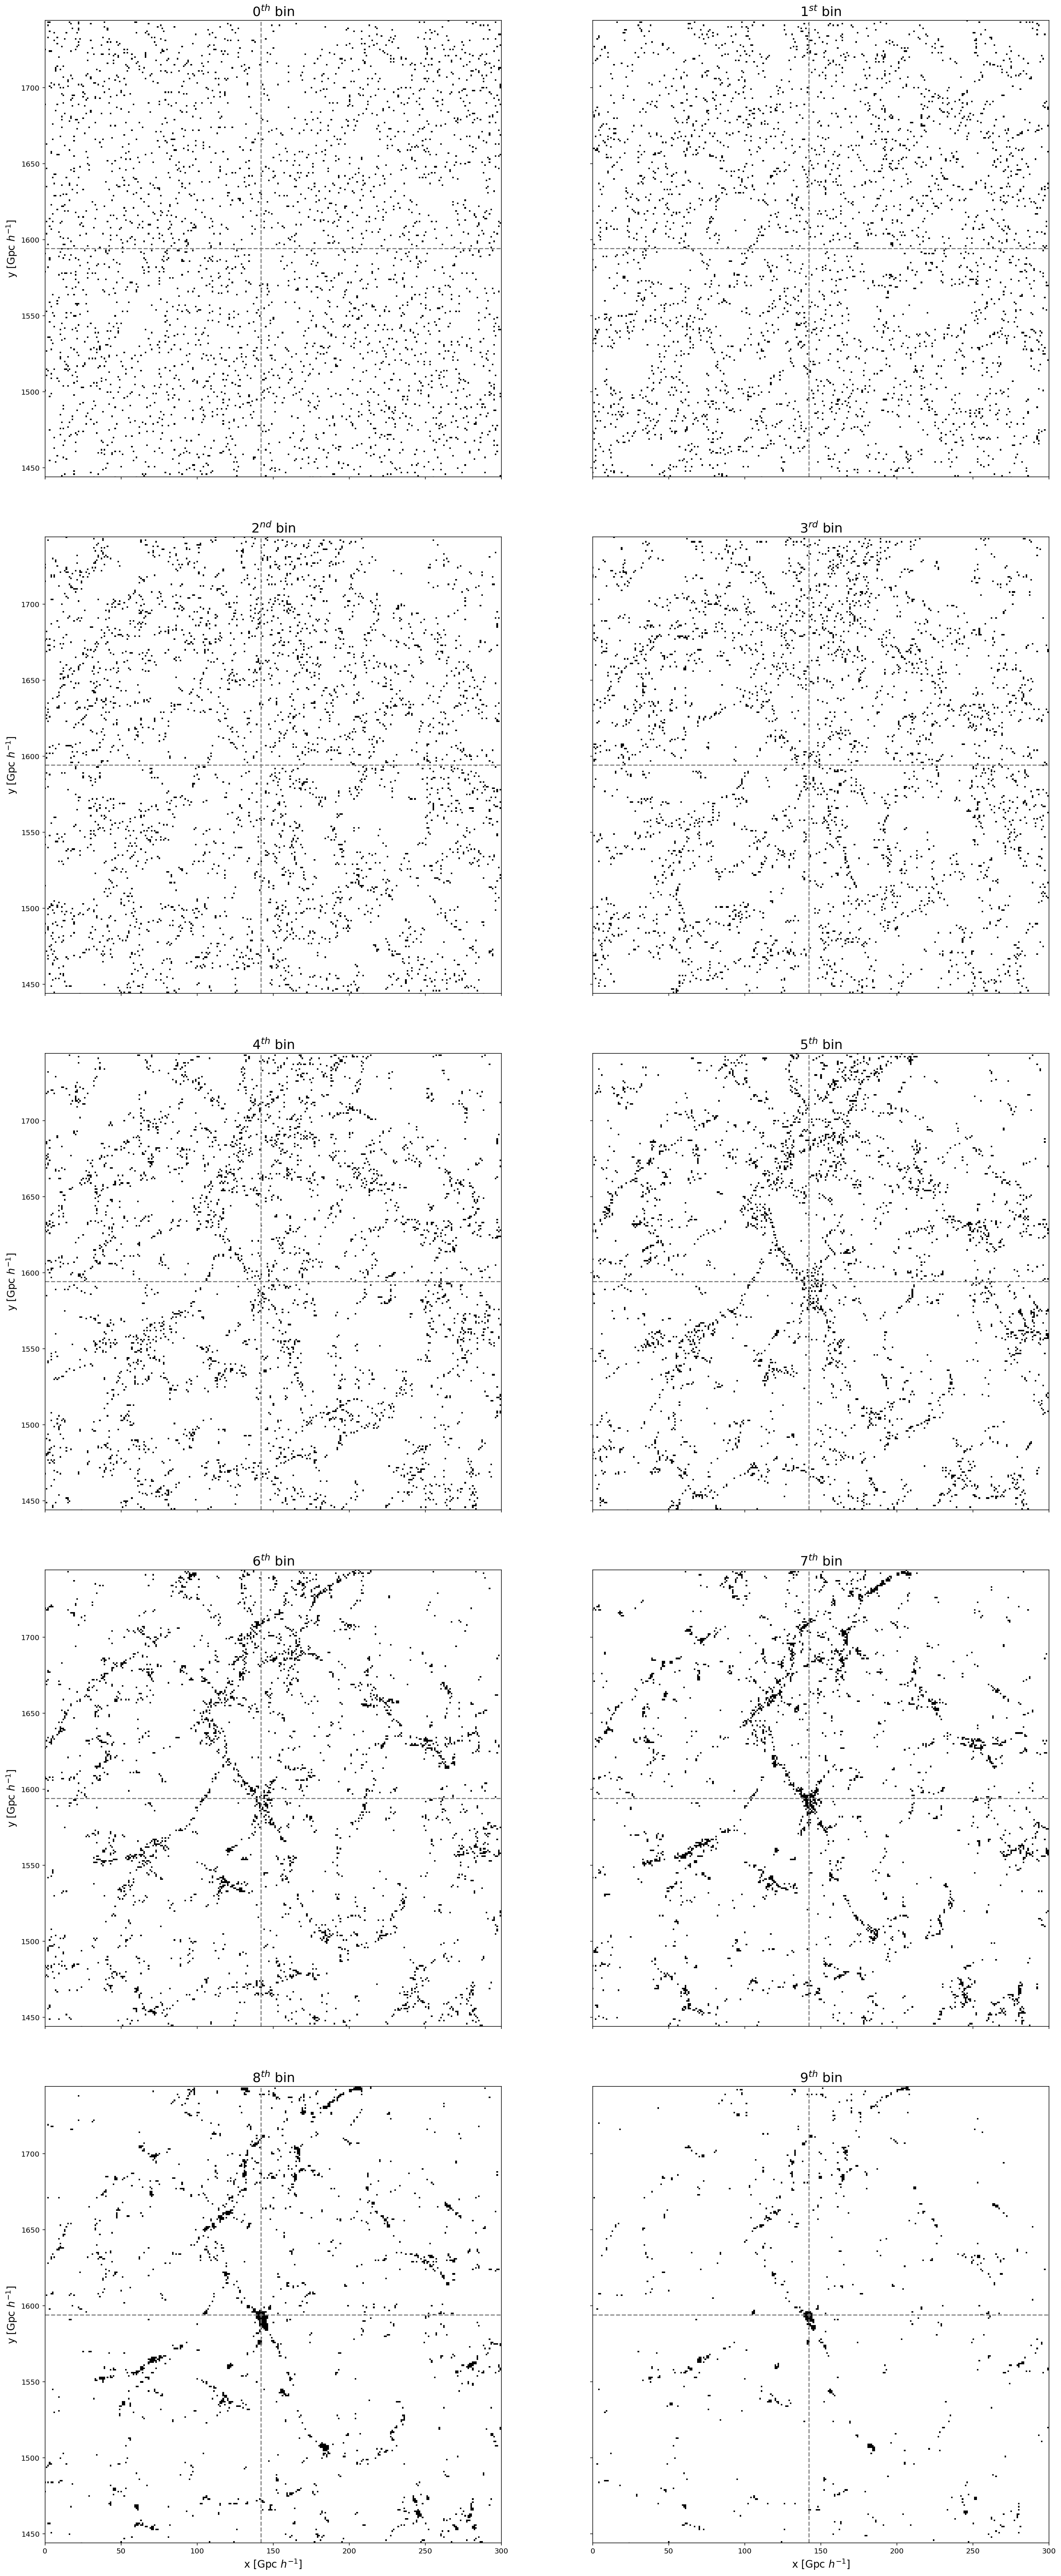

In [5]:
LOS_depth = 10 # Gpc/h
window_size = 300 # Gpc/h

fig, axs = plt.subplots(5, 2, figsize=(20,50), sharex=True, sharey=True)
imgs = np.zeros((10,BoxSize,BoxSize))
ptile_labels = [r'$0^{th}$ bin', r'$1^{st}$ bin', r'$2^{nd}$ bin', r'$3^{rd}$ bin', r'$4^{th}$ bin', r'$5^{th}$ bin', r'$6^{th}$ bin', r'$7^{th}$ bin', r'$8^{th}$ bin', r'$9^{th}$ bin']

t1 = time.time()
max_idx = np.argmax(cat['HALO_MASS'])
max_halo_x, max_halo_y, max_halo_z = cat['x'][max_idx], cat['y'][max_idx], cat['z'][max_idx]
t2 = time.time()
print("Found most massive halo in %s"%str(timedelta(seconds=t2-t1)))

x_lower_guess, x_upper_guess = max_halo_x-window_size/2, max_halo_x+window_size/2
x_lower, x_upper = coord_bounds(x_lower_guess, x_upper_guess, BoxSize, window_size)

y_lower_guess, y_upper_guess = max_halo_y-window_size/2, max_halo_y+window_size/2
y_lower, y_upper = coord_bounds(y_lower_guess, y_upper_guess, BoxSize, window_size)

z_lower_guess, z_upper_guess = max_halo_z-LOS_depth/2, max_halo_z+LOS_depth/2
z_lower, z_upper = coord_bounds(z_lower_guess, z_upper_guess, BoxSize, LOS_depth)

region = np.asarray([[x_lower,x_upper], [y_lower,y_upper], [z_lower,z_upper]])

np.savetxt('plots/show_densityfield/massive_halo_region.txt', region,
           header='x,y,z bounds of displayed region around most massive halo in Gpc/h')


for i, ax in enumerate(axs.flatten()):
    t1 = time.time()
    # select galaxies in percentile and xyz range
    mask = np.load('power_densitybins/selection_ptile_%d.npy'%i)
    gals_sel = cat[mask]
    gals = gals_sel[(gals_sel['x']>x_lower)*(gals_sel['x']<x_upper)*(gals_sel['y']>y_lower)*(gals_sel['y']<y_upper)*(gals_sel['z']>z_lower)*(gals_sel['z']<z_upper)]
    gals_x, gals_y = np.array(gals['x'], dtype='int16'), np.array(gals['y'], dtype='int16')

    # Note that y coord labels rows and x coord columns 
    for j in range(len(gals_x)):
        imgs[i][gals_y[j]][gals_x[j]] = 1

    ax.imshow(imgs[i], origin='lower', cmap='binary')
    ax.set_title(ptile_labels[i], fontsize=18)
    ax.vlines(max_halo_x, y_lower, y_upper, linestyle='--', color='grey')
    ax.hlines(max_halo_y, x_lower, x_upper, linestyle='--', color='grey')
    ax.set_xlim([x_lower, x_upper])
    ax.set_ylim([y_lower, y_upper])
    
    if i in [8,9]:
        ax.set_xlabel(r'x [$\mathrm{Gpc} \ h^{-1}$]', fontsize=14)
    if i in [0,2,4,6,8]:
        ax.set_ylabel(r'y [$\mathrm{Gpc} \ h^{-1}$]', fontsize=14)
       
    t2 = time.time()
    print("Painted bin %d in %s"%(i,str(timedelta(seconds=t2-t1))))

        
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

#fig.savefig('plots/show_densityfield/massive_halo_bins.pdf')

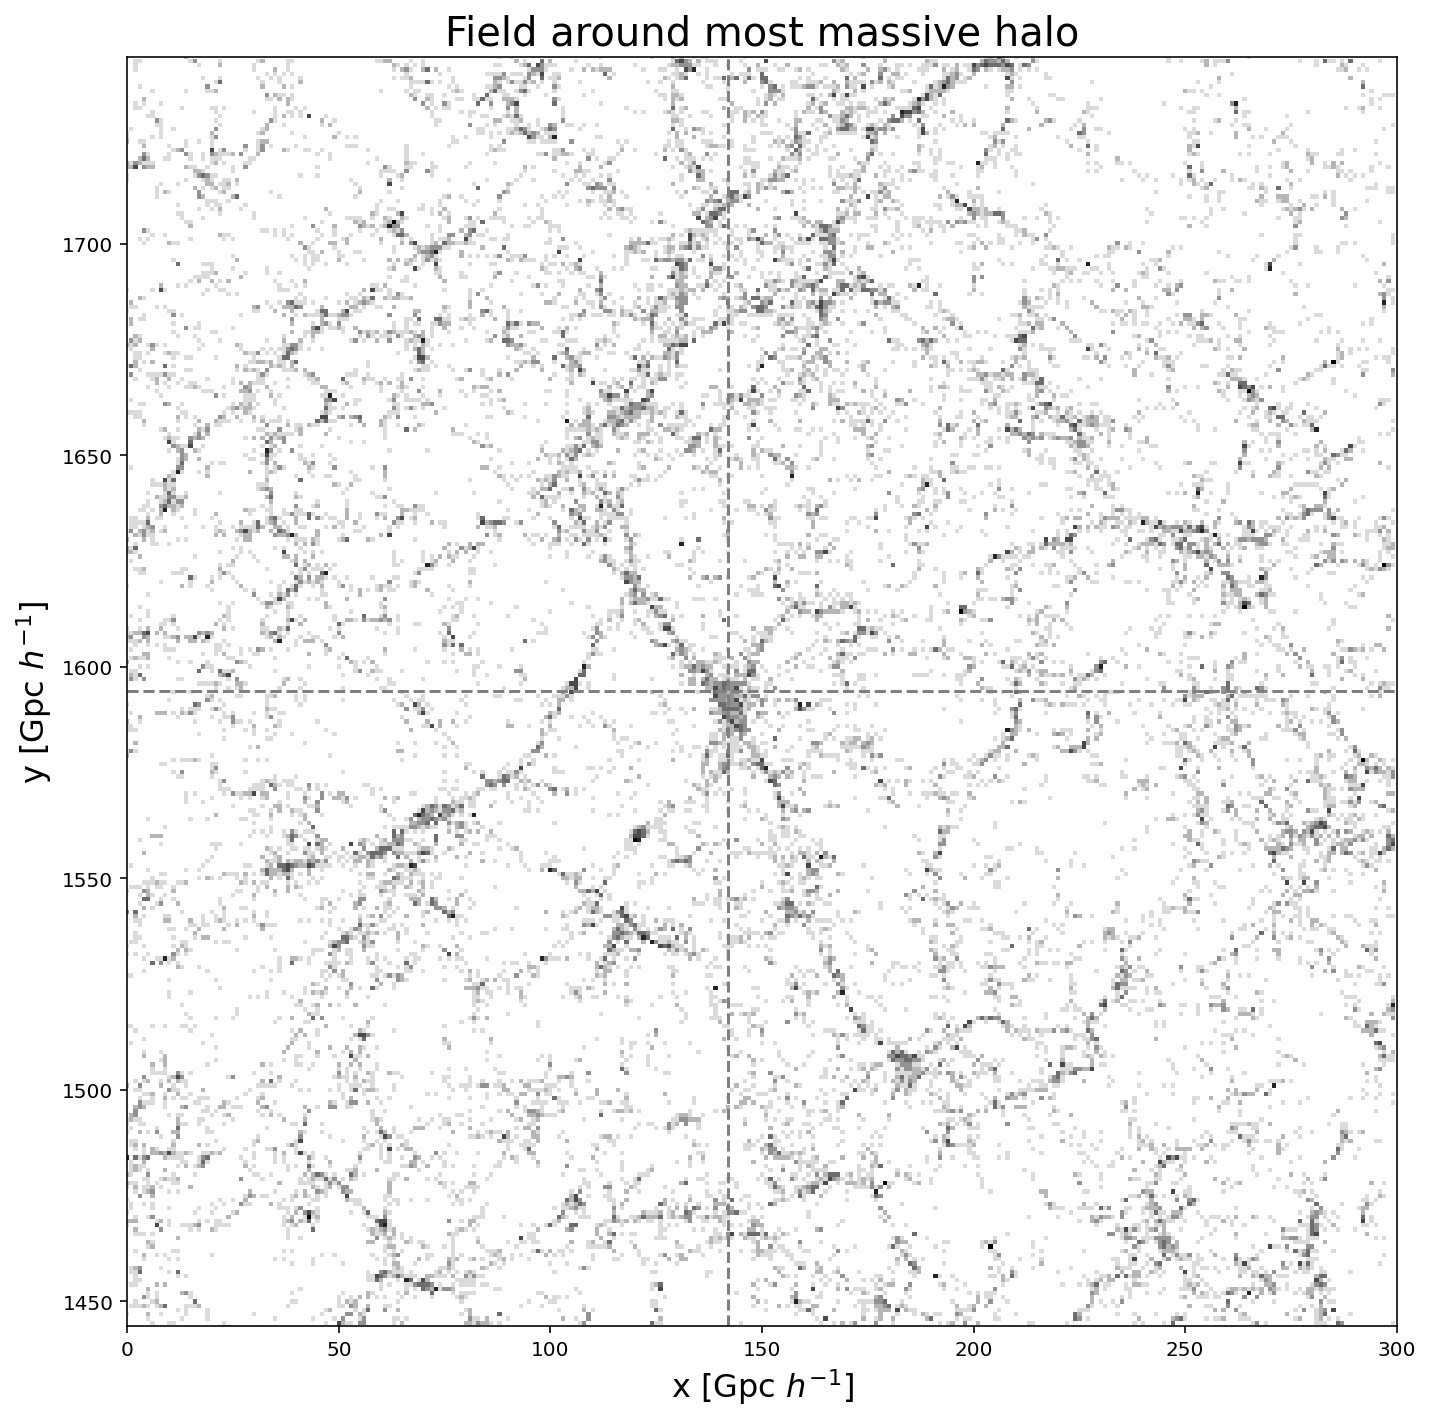

In [6]:
# Combine to single figure
fig, ax = plt.subplots(figsize=(10,10))

img = np.sum(imgs, axis=0)

ax.imshow(img, origin='lower', cmap='binary')
ax.vlines(max_halo_x, y_lower, y_upper, linestyle='--', color='grey')
ax.hlines(max_halo_y, x_lower, x_upper, linestyle='--', color='grey')
ax.set_xlim([x_lower, x_upper])
ax.set_ylim([y_lower, y_upper])

ax.set_title(r'Field around most massive halo', fontsize=20)
ax.set_xlabel(r'x [$\mathrm{Gpc} \ h^{-1}$]', fontsize=16)
ax.set_ylabel(r'y [$\mathrm{Gpc} \ h^{-1}$]', fontsize=16)
    
fig.tight_layout()
plt.show()

#fig.savefig('plots/show_densityfield/massive_halo.pdf')

### Plot full field of single bin in specified z range

Painted percentile 9 in 0:00:17.978889


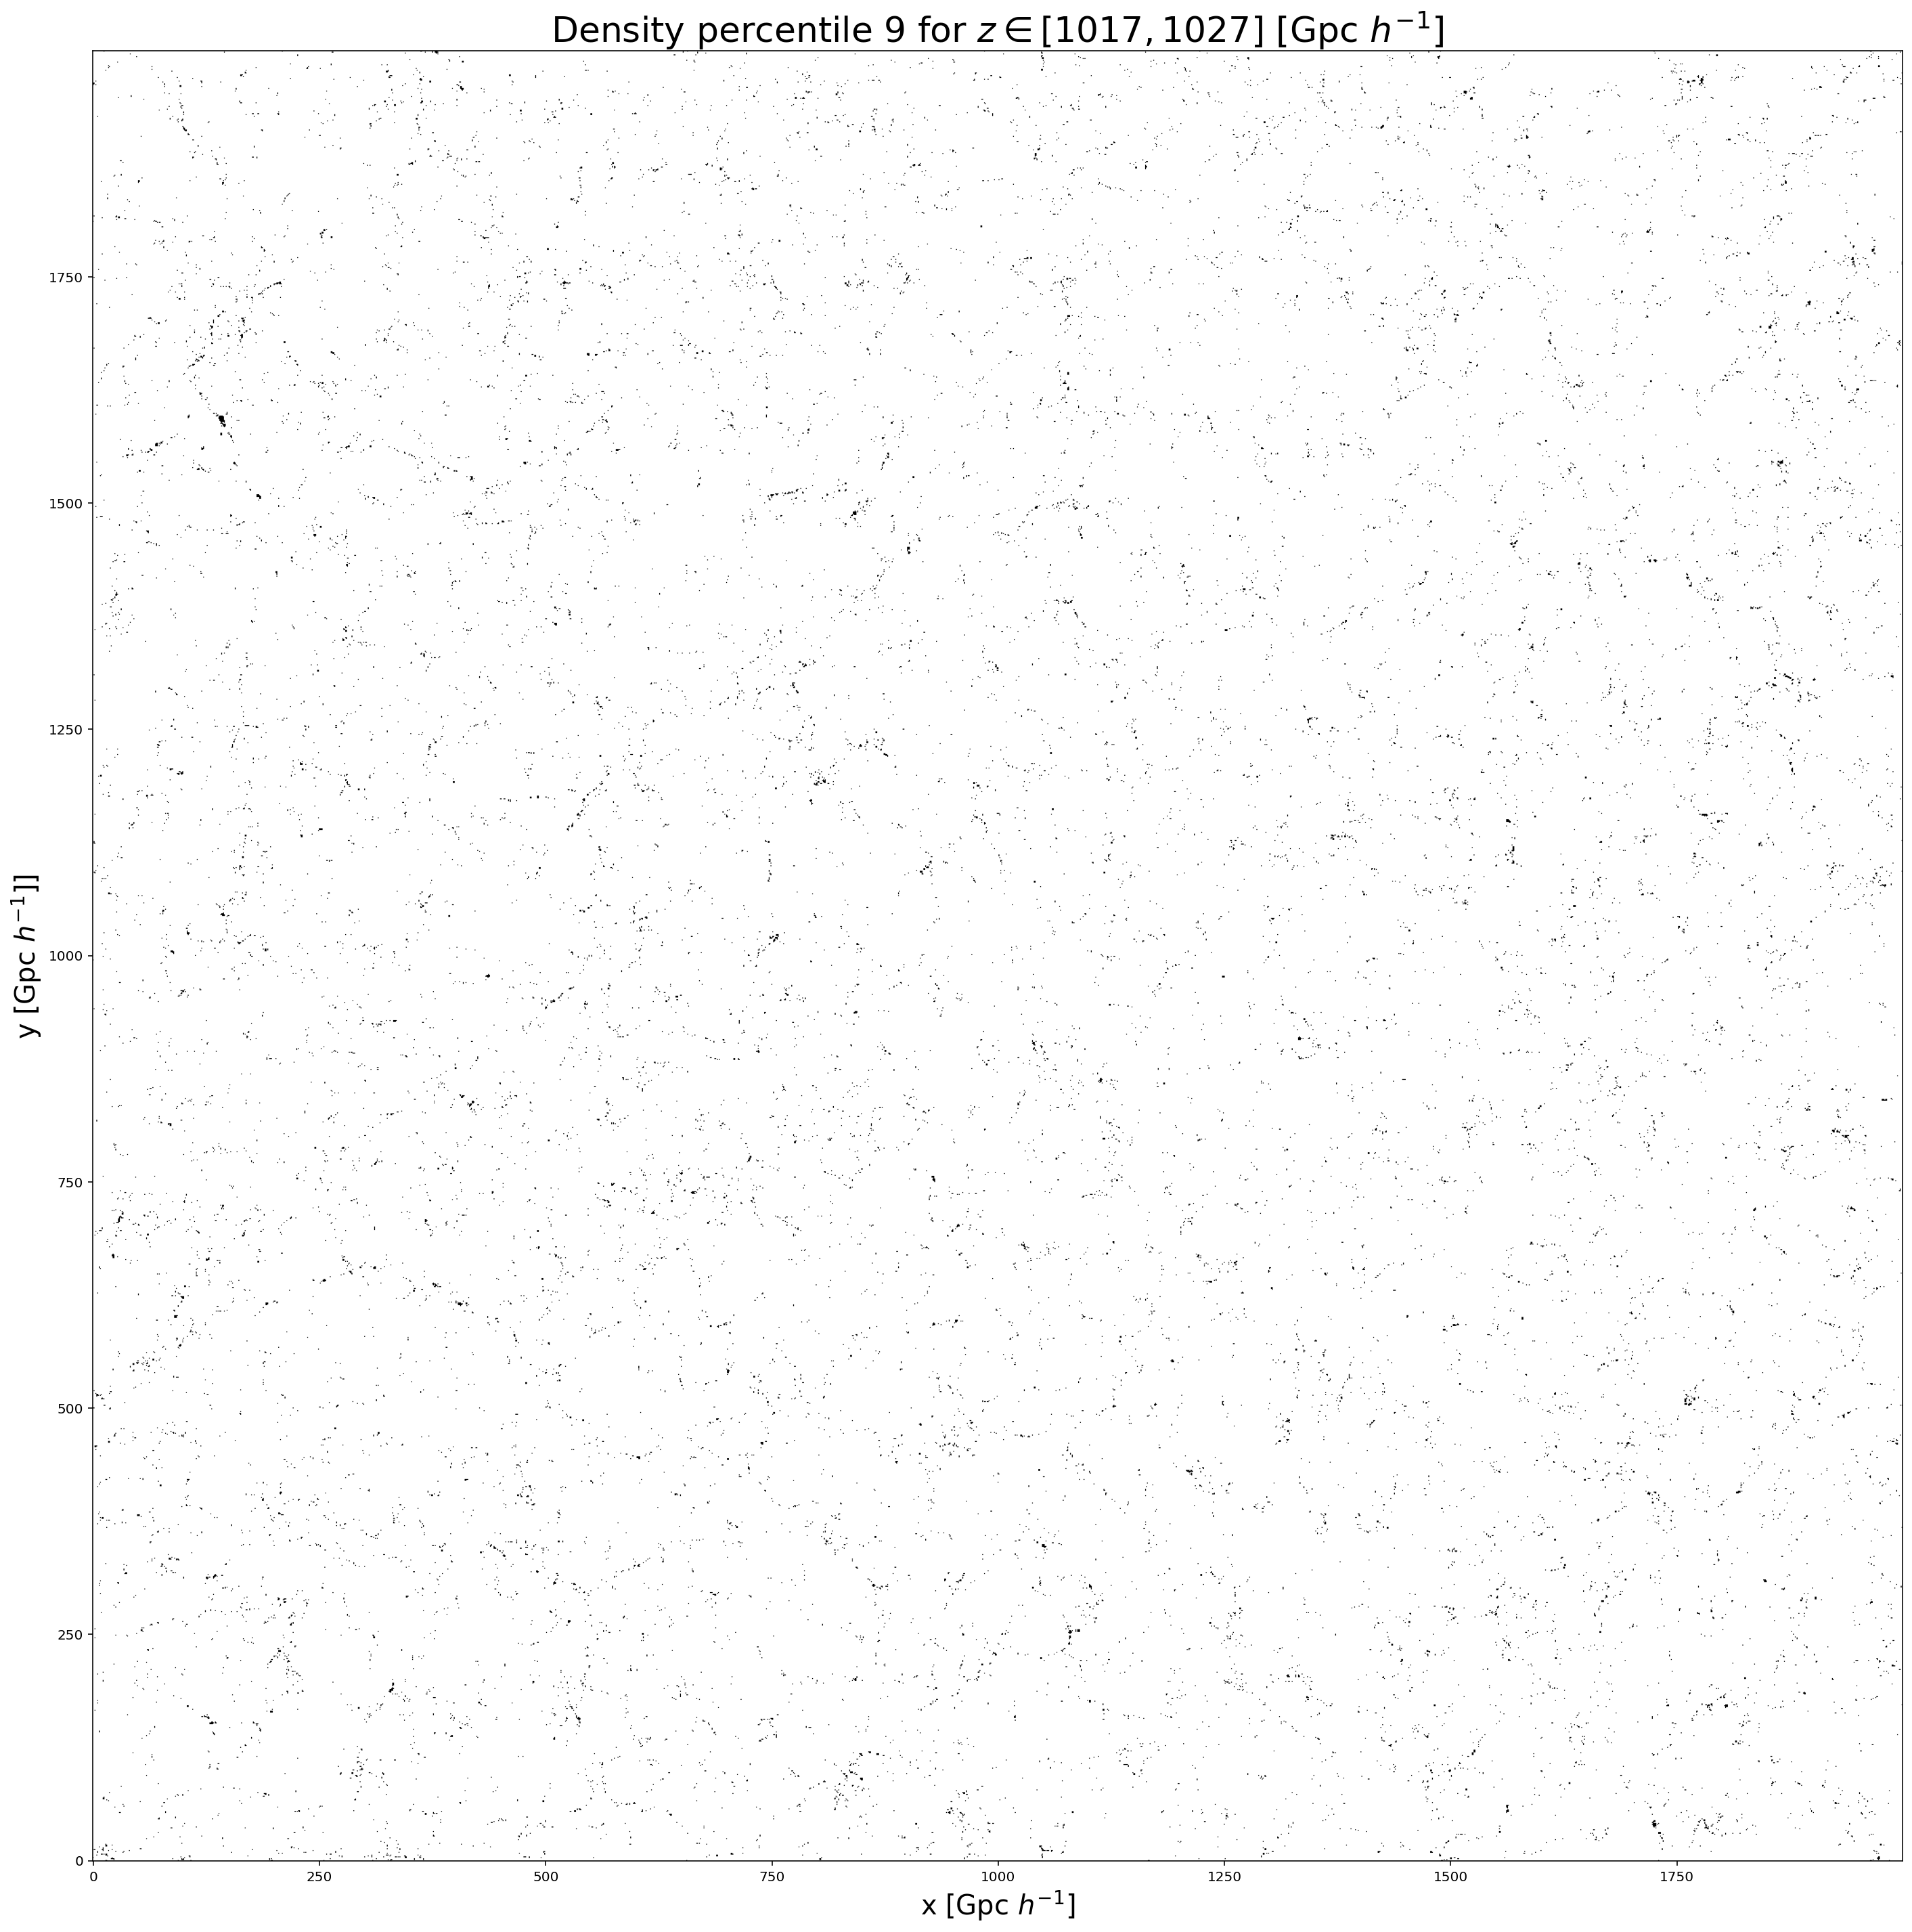

In [14]:
i = 9
z_min, z_max = 1.017185546875000000e+03, 1.027185546875000000e+03

fig, ax = plt.subplots(figsize=(20,20))

t1 = time.time()
# selected galaxies must be in percentile and in considered z range
mask = np.load('power_densitybins/selection_ptile_%d.npy'%i)
gals_sel = cat[mask]
gals = gals_sel[(gals_sel['z']>z_min)*(gals_sel['z']<z_max)]
gals_x, gals_y = np.array(gals['x'], dtype='int16'), np.array(gals['y'], dtype='int16')

img = np.zeros((BoxSize,BoxSize))

for j in range(len(gals_x)):
    # deal with edge cases
    if gals_x[j] == BoxSize:
        gals_x[j] = BoxSize-1
    if gals_y[j] == BoxSize:
        gals_y[j] = BoxSize-1
    # Note that y coord labels rows and x coord columns
    img[gals_y[j]][gals_x[j]] = 1

ax.imshow(img, origin='lower', cmap='binary')
ax.set_title(r'Density percentile %d for $z \in [%d,%d]$ [$\mathrm{Gpc} \ h^{-1}$]'%(i,z_min,z_max), fontsize=26)
ax.set_xlabel(r'x [$\mathrm{Gpc} \ h^{-1}$]', fontsize=20)
ax.set_ylabel(r'y [$\mathrm{Gpc} \ h^{-1}$]]', fontsize=20)
t2 = time.time()
print('Painted percentile %d in %s'%(i,str(timedelta(seconds=t2-t1))))
    
fig.tight_layout()
plt.show()

fig.savefig('plots/show_densityfield/ptile%d.pdf'%i)